<a href="https://colab.research.google.com/github/rchong3/EEG-TBI-Research/blob/main/ChongRichard_HERO_EEG_TBILearnNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import sys

!{sys.executable} -m pip install --upgrade pip scipy mne matplotlib==3.1.3 numpy pandas sklearn torch

     |████████████████████████████████| 13.1 MB 92 kB/s 
  Attempting uninstall: matplotlib
    Found existing installation: matplotlib 3.4.3
    Uninstalling matplotlib-3.4.3:
      Successfully uninstalled matplotlib-3.4.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
albumentations 0.1.12 requires imgaug<0.2.7,>=0.2.5, but you have imgaug 0.2.9 which is incompatible.


In [19]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [2]:
import os
import time

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
from scipy import signal
from sklearn.preprocessing import Normalizer

In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [4]:
X_train = np.load('/content/drive/MyDrive/EEG Research/thresholded_dataset/X_train.npy')
X_val = np.load('/content/drive/MyDrive/EEG Research/thresholded_dataset/X_valid.npy')
X_test  = np.load('/content/drive/MyDrive/EEG Research/thresholded_dataset/X_test.npy')
y_train = np.load('/content/drive/MyDrive/EEG Research/thresholded_dataset/y_train.npy')
y_val = np.load('/content/drive/MyDrive/EEG Research/thresholded_dataset/y_valid.npy')
y_test = np.load('/content/drive/MyDrive/EEG Research/thresholded_dataset/y_test.npy')
print(*map(len, (X_train, X_val, X_test)))

121886 36802 41512


In [5]:
sig = np.vstack((X_train, X_val, X_test))
x_shape = sig.shape
sig = np.vstack(sig)
del X_train, X_val, X_test

In [6]:
filt = signal.firwin2(301, [0, 0.5, 50, 125], [0, 1, 0, 0], antisymmetric=True, fs=250)
norm = Normalizer()
norm.fit(sig)

Normalizer(copy=True, norm='l2')

In [7]:
class EEGDataset(torch.utils.data.Dataset):
    def __init__(self, X, y):
        super(EEGDataset).__init__()
        assert len(X) == len(y), "X and y must be the same length"
        self.features = X
        self.labels = y
    
    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        return (self.features[idx], self.labels[idx]) if idx < len(self.features) else (np.flip(self.features[idx-len(self.features)], -1).copy(), self.labels[idx-len(self.features)].copy())
    
    def __len__(self):
        return len(self.features) * 2

In [8]:
sig.shape

(400400, 1001)

In [9]:
for i in range(4):
  sig[100100 * i: 100100 * (i + 1)] = signal.filtfilt(filt, 1, sig[100100 * i: 100100 * (i + 1)])
  print(i, end=' ')

0 1 2 3 

In [10]:
# del train_ds, train_loader, val_ds, val_loader, test_ds, test_loader
batch_size = 256
trans_x = np.reshape(norm.transform(sig), x_shape)
train_ds = EEGDataset(trans_x[0:len(y_train)], np.expand_dims(y_train, 1))
train_loader = torch.utils.data.DataLoader(train_ds, batch_size=batch_size, shuffle=True)
val_ds = EEGDataset(trans_x[len(y_train):len(y_train)+len(y_val)], np.expand_dims(y_val, 1))
val_loader = torch.utils.data.DataLoader(val_ds, batch_size=batch_size, shuffle=True)
test_ds = EEGDataset(trans_x[len(y_train)+len(y_val):], np.expand_dims(y_test, 1))
test_loader = torch.utils.data.DataLoader(test_ds, batch_size=batch_size, shuffle=True)
del trans_x

In [ ]:
sham = []
tbi = []
for i, info in enumerate(train_loader):
    inputs, labels = info
    for i in range(len(inputs)):
        if labels[i][0] == 0:
            sham.append(inputs[i].numpy())
        else:
            tbi.append(inputs[i].numpy())
sham = np.array(sham)
tbi = np.array(tbi)

In [ ]:
sham = sham.flatten()
tbi = tbi.flatten()
print(sham.mean(), sham.var(), sham.min(), sham.max())
print(tbi.mean(), tbi.var(), tbi.min(), tbi.max())
del tbi, sham
# Only filtered output:
# -1.1597888715637884e-08 3.604156743964423e-10 -0.0005247564615342321 0.0004408528038845851
# 3.3504352079578704e-09 4.909679400001638e-10 -0.000974597787117513 0.0009072672084706262
# Normalized output:
# -3.266138637547733e-05 0.0009989999322348416 -0.30677928831480655 0.33822366223274036
# -6.859868180599429e-06 0.0009990009519432069 -0.26629351918991717 0.31463573788142524

In [11]:
class ResNet(nn.Module):
    def __init__(self, num_features):
        super(ResNet, self).__init__()
        n_feature_maps = 64
        
        self.conv1 = nn.Conv1d(num_features, n_feature_maps, 8, padding='same')
        self.conv2 = nn.Conv1d(n_feature_maps, n_feature_maps, 5, padding='same')
        self.conv3 = nn.Conv1d(n_feature_maps, n_feature_maps, 3, padding='same')
        self.conv4 = nn.Conv1d(num_features, n_feature_maps, 1, padding='same')
        self.conv5 = nn.Conv1d(n_feature_maps, n_feature_maps * 2, 8, padding='same')
        self.conv6 = nn.Conv1d(n_feature_maps * 2, n_feature_maps * 2, 5, padding='same')
        self.conv7 = nn.Conv1d(n_feature_maps * 2, n_feature_maps * 2, 3, padding='same')
        self.conv8 = nn.Conv1d(n_feature_maps, n_feature_maps * 2, 1, padding='same')
        self.conv9 = nn.Conv1d(n_feature_maps * 2, n_feature_maps * 2, 8, padding='same')
        self.conv10 = nn.Conv1d(n_feature_maps * 2, n_feature_maps * 2, 5, padding='same')
        self.conv11 = nn.Conv1d(n_feature_maps * 2, n_feature_maps * 2, 3, padding='same')
        
        self.bn1 = nn.BatchNorm1d(n_feature_maps)
        self.bn2 = nn.BatchNorm1d(n_feature_maps)
        self.bn3 = nn.BatchNorm1d(n_feature_maps)
        self.bn4 = nn.BatchNorm1d(n_feature_maps)
        self.bn5 = nn.BatchNorm1d(n_feature_maps * 2)
        self.bn6 = nn.BatchNorm1d(n_feature_maps * 2)
        self.bn7 = nn.BatchNorm1d(n_feature_maps * 2)
        self.bn8 = nn.BatchNorm1d(n_feature_maps * 2)
        self.bn9 = nn.BatchNorm1d(n_feature_maps * 2)
        self.bn10 = nn.BatchNorm1d(n_feature_maps * 2)
        self.bn11 = nn.BatchNorm1d(n_feature_maps * 2)
        self.bn12 = nn.BatchNorm1d(n_feature_maps * 2)
        
        self.relu_out = nn.ReLU()
        self.avgpool = nn.AdaptiveAvgPool1d(1)
        self.linear = nn.Linear(n_feature_maps * 2, 2)
  
    def forward(self, x):
        # BLOCK 1
        
        conv_x = F.relu(self.bn1(self.conv1(x)))
        conv_y = F.relu(self.bn2(self.conv2(conv_x)))
        conv_z = self.bn3(self.conv3(conv_y))
        # expand channels for the sum
        shortcut_y = self.bn4(self.conv4(x))
        output_block_1 = F.relu(shortcut_y + conv_z)
        
        # BLOCK 2
        
        conv_x = F.relu(self.bn5(self.conv5(output_block_1)))
        conv_y = F.relu(self.bn6(self.conv6(conv_x)))
        conv_z = self.bn7(self.conv7(conv_y))
        # expand channels for the sum
        shortcut_y = self.bn8(self.conv8(output_block_1))
        output_block_2 = F.relu(shortcut_y + conv_z)
        
        # BLOCK 3
        
        conv_x = F.relu(self.bn9(self.conv9(output_block_2)))
        conv_y = F.relu(self.bn10(self.conv10(conv_x)))
        conv_z = self.bn11(self.conv11(conv_y))
        # no need to expand channels because they are equal
        shortcut_y = self.bn12(output_block_2)
        output_block_3 = self.relu_out(shortcut_y + conv_z)
        
        # FINAL
        
        gap_layer = self.avgpool(output_block_3)
        output_layer = F.softmax(self.linear(torch.flatten(gap_layer, 1)), dim=1)
        
        return output_layer
        

In [12]:
def train(model, train_loader, criterion, optimizer, device, show_interval=20):
    start_time = time.time()
    train_loss, running_loss, correct, count = 0, 0, 0, 0
    length = len(train_loader)

    model.train()

    for i, info in enumerate(train_loader):
        inputs, labels = info
        
        optimizer.zero_grad()

        outputs = model(inputs.to(device))

        predicted = torch.round(outputs[:,1].data)
        correct += (predicted == labels[:,0].to(device)).sum()

        one_hot = torch.tensor(np.hstack([1 - labels, labels])).double()
        loss = criterion(outputs.to(device), one_hot.to(device))
        loss.backward()
        optimizer.step()

        train_loss += loss * inputs.size(0)
        running_loss += loss * inputs.size(0)
        count += inputs.size(0)

        if i % show_interval == (show_interval - 1):
            print(f'Batch {i + 1}/{length} - loss: {running_loss / show_interval: .5f} accuracy: {correct / count: .5f} time: {time.time() - start_time: .5f} s')
            running_loss = 0.0
  
    print('time:', time.time() - start_time, 's')

    return train_loss.item() / count, correct.item() / count

def evaluate(model, loader, criterion, optimizer, device, show_interval=20):
    start_time = time.time()
    val_loss, running_loss, correct, count = 0, 0, 0, 0
    length = len(loader)

    model.eval()

    with torch.no_grad():
        for i, info in enumerate(loader):
            inputs, labels = info

            outputs = model(inputs.to(device))

            predicted = torch.round(outputs[:,1].data)
            correct += (predicted == labels[:,0].to(device)).sum()

            one_hot = torch.tensor(np.hstack([1 - labels, labels])).double()
            loss = criterion(outputs.to(device), one_hot.to(device))

            val_loss += loss * inputs.size(0)
            running_loss += loss * inputs.size(0)
            count += inputs.size(0)

            if i % show_interval == show_interval - 1:
                print(f'Batch {i + 1}/{length} - loss: {running_loss / show_interval: .5f} accuracy: {correct / count: .5f} time: {time.time() - start_time: .5f} s')
                running_loss = 0.0
    
    print('time:', time.time() - start_time, 's')

    return val_loss.item() / count, correct.item() / count

In [13]:
model = ResNet(2).double().to(device)
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

In [ ]:
for epoch in range(2):
    print('Epoch', epoch + 1)
    print('Training')
    train_loss, train_accuracy = train(model, train_loader, criterion, optimizer, device, 40)
    print('training results - loss:', train_loss, 'accuracy:', train_accuracy)
    print('Validating')
    val_loss, val_accuracy = evaluate(model, val_loader, criterion, optimizer, device, 20)
    print('validation results - loss:', val_loss, 'accuracy:', val_accuracy)
    torch.save(model, f'./model_rev_e{epoch+1}.pth')
print('Finished Training')

Epoch 1
Training


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/conv.py:295: UserWarning: Using padding='same' with even kernel lengths and odd dilation may require a zero-padded copy of the input be created (Triggered internally at  /pytorch/aten/src/ATen/native/Convolution.cpp:660.)
  self.padding, self.dilation, self.groups)


Batch 40/953 - loss:  149.94932 accuracy:  0.70498 time:  69.23133 s
Batch 80/953 - loss:  106.98448 accuracy:  0.76250 time:  138.00232 s
Batch 120/953 - loss:  89.63766 accuracy:  0.79082 time:  206.79179 s
Batch 160/953 - loss:  81.80857 accuracy:  0.81021 time:  275.44799 s
Batch 200/953 - loss:  74.96315 accuracy:  0.82449 time:  344.12755 s
Batch 240/953 - loss:  67.96720 accuracy:  0.83608 time:  412.78209 s
Batch 280/953 - loss:  66.00582 accuracy:  0.84427 time:  481.48056 s
Batch 320/953 - loss:  59.74018 accuracy:  0.85188 time:  550.26881 s
Batch 360/953 - loss:  58.79979 accuracy:  0.85820 time:  618.98068 s
Batch 400/953 - loss:  57.27735 accuracy:  0.86331 time:  687.67670 s
Batch 440/953 - loss:  57.72158 accuracy:  0.86763 time:  756.38760 s
Batch 480/953 - loss:  56.37815 accuracy:  0.87131 time:  825.09075 s
Batch 520/953 - loss:  52.67043 accuracy:  0.87498 time:  893.76992 s
Batch 560/953 - loss:  52.66626 accuracy:  0.87789 time:  962.46876 s
Batch 600/953 - loss:

In [14]:
class Hook():
    def __init__(self,m):
        self.hook = m.register_forward_hook(self.hook_func)
    def hook_func(self,m,i,o):
        self.stored = o.detach().clone()
    def __enter__(self, *args): return self
    def __exit__(self, *args):
        self.hook.remove()

In [15]:
def get_cam(model, x, y):
    params = list(model.linear.parameters())
    weight = np.squeeze(params[0].data.cpu().numpy())
    test_model.eval()
    with Hook(model.conv11) as hook:
        with torch.no_grad():
            output = model(x.to(device))
        idx = output.argmax()
        feat_maps = hook.stored
    feature_conv = feat_maps.detach().cpu().numpy()
    beforeDot = feature_conv.reshape((128, 1001))
    cam = np.matmul(weight[idx], beforeDot)
    cam = cam - np.min(cam)
    cam = np.uint8(cam / np.max(cam) * 255)
    return cam

In [20]:
test_model = torch.load('model_rev_e1.pth')

In [21]:
inputs, labels = next(iter(test_loader))
x = inputs[0:1]
y = labels[0:1]
cam = get_cam(test_model, x, y)

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/conv.py:295: UserWarning: Using padding='same' with even kernel lengths and odd dilation may require a zero-padded copy of the input be created (Triggered internally at  /pytorch/aten/src/ATen/native/Convolution.cpp:660.)
  self.padding, self.dilation, self.groups)


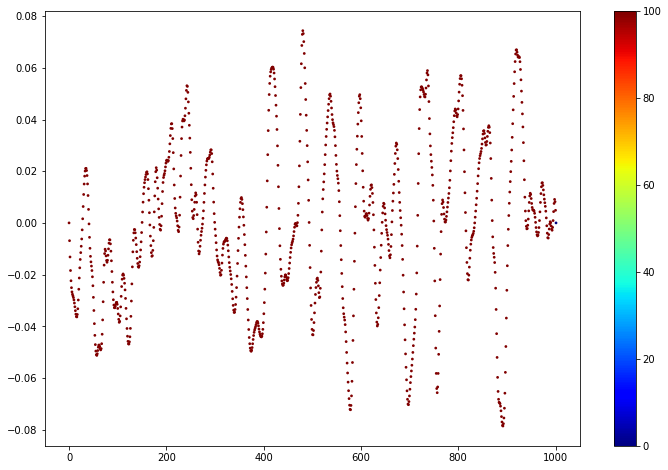

In [22]:
plt.figure(figsize=(12, 8))
plt.scatter(x=np.linspace(0, 1001, 1001), y=x[0][0], c=cam, cmap='jet', marker='.', s=30, vmin=0, vmax=100, linewidths=0.0)
cbar = plt.colorbar()

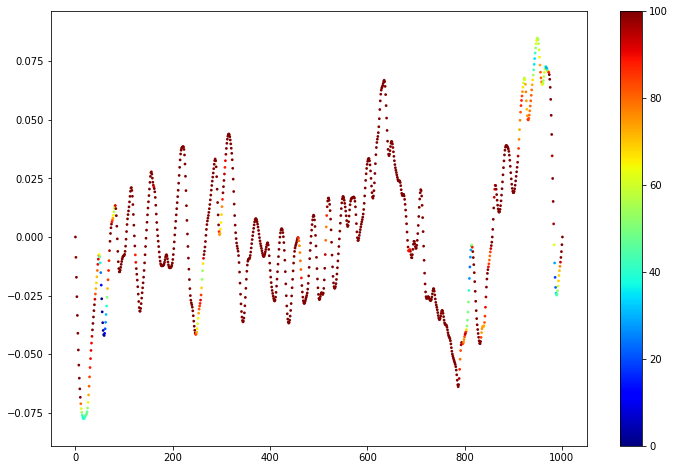

In [ ]:
plt.figure(figsize=(12, 8))
plt.scatter(x=np.linspace(0, 1001, 1001), y=x[0][1], c=cam, cmap='jet', marker='.', s=30, vmin=0, vmax=100, linewidths=0.0)
cbar = plt.colorbar()

In [ ]:
test_loss, test_accuracy = evaluate(test_model, test_loader, criterion, optimizer, device, 20)
print('test - loss:', test_loss, 'accuracy:', test_accuracy)

Batch 20/325 - loss:  279.01689 accuracy:  0.50195 time:  10.30537 s
Batch 40/325 - loss:  281.59647 accuracy:  0.50283 time:  20.57234 s
Batch 60/325 - loss:  286.91645 accuracy:  0.49714 time:  30.81705 s
Batch 80/325 - loss:  282.60873 accuracy:  0.49419 time:  41.02049 s
Batch 100/325 - loss:  282.78397 accuracy:  0.49520 time:  51.24669 s


KeyboardInterrupt: ignored